*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  01.07.2024

--- 

# Emission gridding

<!--Notebook description and usage information-->
This notebook is used to convert line source emissions into a gridded inventory. The unit of the line source emissions is g/m, therefore, multiplication with the line length and a unit conversion is required. The script handles different vehicle classes and components which are to be set in the notebook settings.

In [1]:
# import libraries

import sys
import warnings
import os
os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('../utils')
import data_paths
from gridding import GriddingEngine

warnings.filterwarnings("ignore")

# Reload local modules on changes
%reload_ext autoreload
%autoreload 2

# Notebook settings

In [2]:
# select year of interest and define filenames for linesource emissions
year_of_interest = '2019'
em_cold_filename = f'linesource_all_munich_{year_of_interest}_cold.gpkg'
em_hot_filename = f'linesource_Munich_{year_of_interest}_los_specific.gpkg'

# define grid for gridding
#grid_file = data_paths.TNO_1km_GRID
grid_file = data_paths.TNO_1km_GRID

# select components and vehicle classes to be considered
vehicle_classes_hot = ['PC', 'LCV', 'HGV', 'MOT', 'BUS']
vehicle_classes_cold = ['PC', 'LCV']

components = ['HC', 'CO2e', 'CO', 'NOx', 'PM', 'PN', 'CO2(rep)',
              'CO2(total)', 'NO2', 'CH4', 'NMHC', 'PM (non-exhaust)', 'Benzene', 'PM2.5',
              'BC (exhaust)', 'PM2.5 (non-exhaust)', 'BC (non-exhaust)']

components = ['CO2(total)']


# include cold start emissions to the final product?
include_cold_start = False

# estimate dominat road type (only available for hot vehicle emissions)
est_road_type = True

# safe result in gepackage
store_results = True
result_filename = f'GNFR_F_hot_CO2_{year_of_interest}_1km_w_roadtype.gpkg'

## Import data

In [3]:
# import hot and cold emission file

# import hot emission results
inventory_path = data_paths.INVENTORY_PATH
em_hot = gpd.read_file(inventory_path + em_hot_filename)

# import cold emission results
if include_cold_start: 
    em_cold = gpd.read_file(inventory_path + em_cold_filename)
    cs_columns = em_cold.columns
    # remove 'geometry' from columns
    cs_components = [col for col in cs_columns if col != 'geometry']
    cs_components = list(set([str(col).split('_')[1] for col in cs_components]))

# import grid
tno_grid = gpd.read_file(grid_file)

## Grid inventory and combine results

In [4]:
# perform gridding
# initialize gridding object
gridding_obj = GriddingEngine(input_grid=tno_grid, crs=em_hot.crs) # hot and cold inventory have the same crs

em_hot_columns = [f'{v}_{c}' for v in vehicle_classes_hot for c in components]
out_grid_hot = gridding_obj.overlay_grid(em_hot, value_columns= em_hot_columns, source_type='line_kilometer', estimate_dominant_road_type = est_road_type)

if include_cold_start:
    em_cold_columns = [f'{v}_{c}' for v in vehicle_classes_cold for c in cs_components]
    out_grid_cold = gridding_obj.overlay_grid(em_cold, value_columns= em_cold_columns, source_type='line_kilometer', estimate_dominant_road_type = False)


In [5]:

gridded_result = pd.DataFrame()
for c in components:
    try:
        hot_cols_to_sum = [f'{v}_{c}' for v in vehicle_classes_hot]
        gridded_result[c] = out_grid_hot[hot_cols_to_sum].sum(axis = 1)
        try:
            if include_cold_start:
                cold_cols_to_sum = [f'{v}_{c}' for v in vehicle_classes_cold]
                gridded_result[c] = out_grid_cold[cold_cols_to_sum].sum(axis = 1) + gridded_result[c]
        except: 
            continue
    except: 
        continue
    
    # convert emissions to kg
    gridded_result[c] = gridded_result[c]/1000

gridded_result['geometry'] = out_grid_hot['geometry']
if include_cold_start:
    gridded_result['geometry'] = out_grid_cold['geometry']
if est_road_type:
    gridded_result['dominant_road_type'] = out_grid_hot['dominant_road_type']
gridded_result = gpd.GeoDataFrame(data= gridded_result, geometry='geometry', crs = em_hot.crs)

## Plot results

Total Emissions of 2019
CO2(total)    1287.339026
dtype: float64


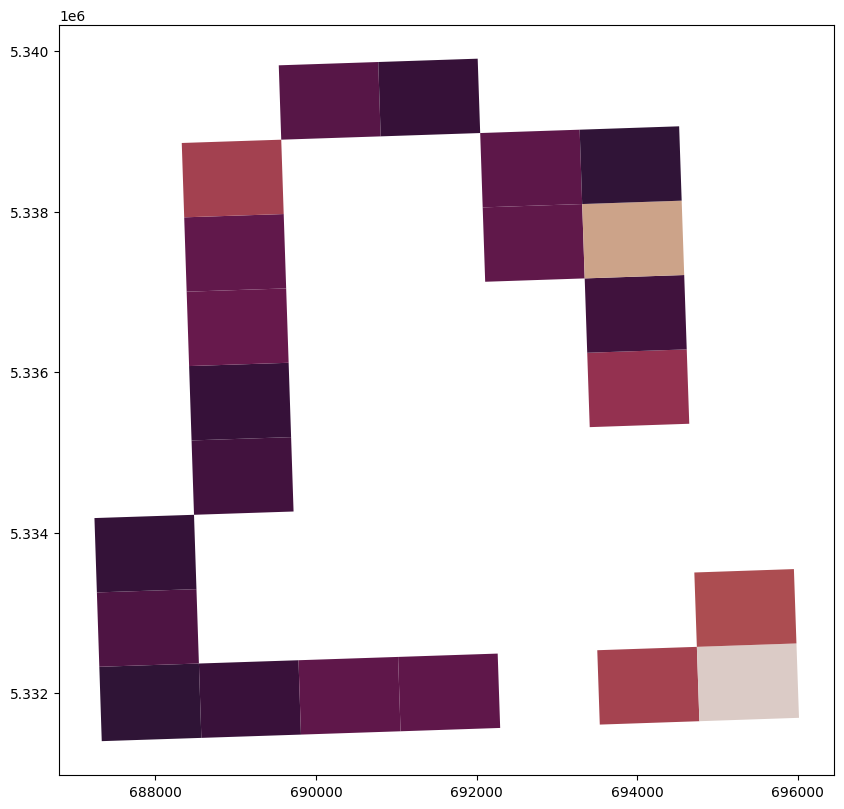

In [6]:
# print totals and plot results

component_to_plot = 'CO2(total)'

# plot results
fig, ax  = plt.subplots(figsize = (10,10), frameon=False)
gridded_result[gridded_result['dominant_road_type']=='TrunkRoad/Primary-City'].plot(ax= ax,
                column= component_to_plot,
                cmap= matplotlib.cm.get_cmap('twilight_shifted'),
                norm= matplotlib.colors.LogNorm())

print(f'Total Emissions of {year_of_interest}')
print(gridded_result.sum(numeric_only=True)*1e-6)

## Save results

In [7]:
# only if store_results is True
if store_results:
    path = data_paths.INVENTORY_PATH
    gridded_result.to_file(path+result_filename, driver = 'GPKG')